# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [27]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import json
from math import floor

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/master/torchvision/transforms.html#)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and 1 instead of 0 and 1.

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([ transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

vali_transforms = transforms.Compose([ transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transforms = transforms.Compose([ transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=vali_transforms)
test_data = datasets.ImageFolder(test_dir, transform=vali_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)


In [4]:
## len(trainloader) returns number of batches that got created from dataset. len(trainoader.dataset) returns number
## of examples that are actually there. len(trainloader) == 103 == 6552/64
len(trainloader),len(trainloader.dataset),len(validloader),len(validloader.dataset),len(testloader),len(testloader.dataset)

(103, 6552, 26, 818, 26, 819)

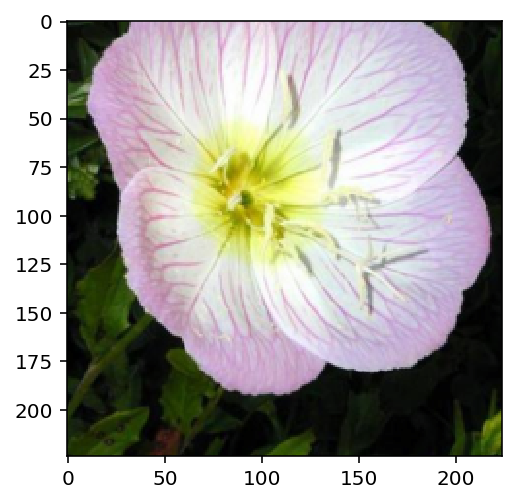

In [5]:
# View an image
images, labels = next(iter(testloader))
fig, ax = plt.subplots()
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = images[0].numpy().transpose((1, 2, 0))
image = std * image + mean
image = np.clip(image, 0, 1)
ax.imshow(image)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
train_data.class_to_idx = cat_to_name
valid_data.class_to_idx = cat_to_name
test_data.class_to_idx = cat_to_name

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [7]:
## We check whether GPU is available on PC or not otherwise we use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
def get_model(model_name):
    """
    Parse the given model name and create a new transfer model.
    Parameters:
        model_name - string, name of the transfer model from torchvision.models
    Returns:
        model - torchvision.models.model, the transfer network model with gradients disabled
    """
    if model_name=='vgg19':
        model = models.vgg19(pretrained=True).to(device)
    elif model_name=='vgg16':
        model = models.vgg16(pretrained=True).to(device)
    elif model_name=='vgg13':
        model = models.vgg13(pretrained=True).to(device)
    elif model_name=='alexnet':
        model = models.alexnet(pretrained=True).to(device)
    else:
        print("\nINPUT ERROR: must select from one of these models: vgg19, vgg16, vgg13, alexnet\n")
    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    return model

In [9]:
# define the hyperparameters# define 
hyperparameters = {'architecture': 'vgg19',
                   'hidden_layers': [4096, 2048, 512],
                   'dropout_rate': 0.3,
                   'learn_rate': 0.0001,
                   'epochs': 18}

In [10]:
# Defining class for a fully-connected network
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, dropout=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            dropout: float between 0 and 1
        '''
        super().__init__()
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [11]:
def validation(model, validloader, criterion, device):
    """
    Validates the model using the test images.

    Parameters:
        model - torchvision.models.model, the neural network model
        validloader - the dataloader for the test set
        criterion - the output loss criterion
        device - torch.device, CPU of GPU
    Returns:
        valid_loss - torch.tensor, the output loss from the validation pass
        accuracy - torch.tensor, the percentage of correctly classified test images
    """
    valid_loss = 0
    accuracy = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Send the model to the desired processor
    model.to(device)

    # Iterate through the test dataloader and do a validation pass on all images
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)

        # Do a forward pass
        output = model.forward(images)

        # Calculate the loss based on the criterion
        valid_loss += criterion(output, labels).item()

        # Since the output is log-loss, the probabilities are the e^x of the output
        ps = torch.exp(output)

        # Check how many of the most probable output results match the labels
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [12]:
# training network

def network_training(model, epochs, learnrate, trainloader, validloader, GPU):

    # Select the GPU if it is available and if GPU is True
    if(GPU==True):
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
        else:
            print("GPU not available. Using CPU instead.")
            device = torch.device("cpu")
    # Otherwise use the CPU
    else:
        device = torch.device("cpu")
    print(f"Device = {device}\n")

    ## We are maintaining list of learning rate and epochs for that particular learning rate which we'll loop through.
    ## We take one learning rate and then do few epochs and then decrease learning rate and then do few epochs with 
    ## that learning rate. We keep on decreasing learning rate until we see that accuracy is improving little bit 
    ## by decreasing learning rate. we generally do not go further down  0.000001.
    ## if learning rate is too high and loss/accuracy is not changing then we decrease learning rate
    # Set up the training parameters
    steps = 0
    running_loss = 0
    print_every = 40
    # Define the criterion and optimizer given the model and learning rate
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=learnrate)

    # Send the model to the correct processor
    model.to(device)

    # Record the start time before training
    start = time.time()
    for e in range(epochs):
        running_loss = 0
        correct = 0
        for images, labels in trainloader:
            steps += 1
            #input data
            images, labels = Variable(images), Variable(labels)   
            images, labels = images.to(device), labels.to(device) ## We call to(device) to transfer tensors between CPU and GPU
            #clear gradients calculated in previous step
            optimizer.zero_grad()       
            #forward +backward
            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()    
            #renew parameter updated according to new gradients and learning rate.
            optimizer.step()  
            _,preds = torch.max(outputs.data, 1)
            ## We caculate from this particular batch how many were caculated/guessed correctly by model.
            correct += (labels == preds).sum()

            #print out 
            running_loss += loss.item()
            
            ## We print loss at every 40 batches to check whether it's decresing or not. Ideally it should decrease.
            if steps % print_every == 0:
                model.eval()
                with torch.no_grad():
                    # Do a validation
                    valid_loss, accuracy = validation(model, validloader, criterion, device)
                    # Print the results 
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Validation Loss: {:.3f}.. ".format(valid_loss/len(validloader)),
                          "Valid Accuracy: {:.3f} %".format((accuracy/len(validloader)*100)))
            
                # Clear the running loss and put the model back in training mode
                running_loss = 0
                model.train()
        print("Epoch: {}/{}.. ".format(e+1, epochs),"Training Loss: {:4f}".format(running_loss/print_every))
        print('Accuracy at %d epoch & Learning Rate : %f is %f %%' % (e+1, learnrate,float(correct) *100 / len(trainloader.dataset)))
        

    print('Finished Training in time : %f seconds' % (time.time() - start))

In [13]:
# Load a pre-trained network into memory and freeze the parameters
model = models.vgg19(pretrained=True)
hyperparameters['architecture'] = 'vgg19'
for param in model.parameters():
    param.requires_grad = False
    
# create the classifier for this pre-trained network

# Check the classifier of the given model and find the first Linear module to see how many inputs it takes
classifier_modules = [type(model.classifier[i]).__name__ for i in range(len(model.classifier))]
First_Linear_Module = classifier_modules.index('Linear')

# Create the classifier for the model 
# Use the transfer models outputs as inputs and the number of image categories as outputs
classifier = Network(model.classifier[First_Linear_Module].in_features, len(train_data.classes), 
                     hyperparameters['hidden_layers'], dropout=hyperparameters['dropout_rate'])

# Attach the classifier to the model
model.classifier = classifier

model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:18<00:00, 30979598.54it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [14]:
# train the network
model_accuracy = network_training(model, 
                               hyperparameters['epochs'], 
                               hyperparameters['learn_rate'],
                               trainloader, 
                               validloader, 
                               GPU=True)

Device = cuda:0

Epoch: 1/18..  Validation Loss: 3.995..  Valid Accuracy: 13.942 %
Epoch: 1/18..  Validation Loss: 2.919..  Valid Accuracy: 33.120 %
Epoch: 1/18..  Training Loss: 1.825724
Accuracy at 1 epoch & Learning Rate : 0.000100 is 14.697802 %
Epoch: 2/18..  Validation Loss: 2.232..  Valid Accuracy: 43.336 %
Epoch: 2/18..  Validation Loss: 1.583..  Valid Accuracy: 58.827 %
Epoch: 2/18..  Validation Loss: 1.315..  Valid Accuracy: 64.476 %
Epoch: 2/18..  Training Loss: 0.319554
Accuracy at 2 epoch & Learning Rate : 0.000100 is 42.139805 %
Epoch: 3/18..  Validation Loss: 1.112..  Valid Accuracy: 69.498 %
Epoch: 3/18..  Validation Loss: 0.941..  Valid Accuracy: 74.132 %
Epoch: 3/18..  Training Loss: 1.091387
Accuracy at 3 epoch & Learning Rate : 0.000100 is 56.440781 %
Epoch: 4/18..  Validation Loss: 0.877..  Valid Accuracy: 76.309 %
Epoch: 4/18..  Validation Loss: 0.773..  Valid Accuracy: 78.218 %
Epoch: 4/18..  Validation Loss: 0.727..  Valid Accuracy: 79.861 %
Epoch: 4/18..  Train

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
# TODO: Do validation on the test set
## We are doing below evaluation on Validation Dataset generated above.
## We need to call model.eval() method to put model in evaluation mode which will freeze BatchNormalization and Dropout layer 
## which does not need to be active during evaluation phase.They only need to be active during training time.
model.eval()

## We need to use torch.no_grad() whenever we are evaluating mode as during this time we doe need to calculate gradients of
## various parameters which we generally do during training time as we need to update this parameters during training but
## not during test/evaluate time.

## Dropout randomly deactivates few neurons in particular layer so that model does not overfit training data
## like we had Linear Layer with 4096 neurons and Dropout of 0.5 will deactivate 50% of neurons which will 
## set only 2048 neurons active in that layer at valid and test time we are evaluating model so we don't worry
## about overfitting as we have model trained and parameters updated Dropout is used to avoid overfitting
with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Accuracy of the network on the %d test images: %d %%' % 
          (len(testloader.dataset), 100 * correct / total ))

Accuracy of the network on the 819 test images: 90 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
%ls
%pwd

assets/           checkpoint.pth                  LICENSE     train.py
cat_to_name.json  flowers/                        predict.py
checkpoint_1.pth  Image Classifier Project.ipynb  README.md


'/home/workspace/aipnd-project'

In [17]:
## Here we save all our weight and baises along with class_to_idx mapping so that we can load it later
## and use model with that trained parameters so that we don't have to waste time in training model every time.
## We get model ready to use by loading parameters.
def save_checkpoint(filepath, model, model_name, input_size, output_size, hyperparams, model_accuracy):
    """
    Save a model checkpoint.

    Parameters:
        filepath - string, the filepath of the checkpoint to be saved
        model - torchvision.models.model, the trained model to be saved
        model_name - string, the name of the transfer model 
        input_size - int, the input size of the classifier's hidden layers
        output_size - int, the output size of the classifier (number of categories)
        hyperparams - dictionary, the hyperparameters of the model training, including epochs, dropout probability, and learnrate
        model_accuracy - float, the accuracy of the trained model
    Returns:
        None
    """
    checkpoint = {'model_name': model_name,
                  'input_size': input_size,
                  'output_size': output_size,
                  'hidden_layers': hyperparams['hidden_layers'],
                  'dropout_rate': hyperparams['dropout_rate'],
                  'learn_rate': hyperparams['learn_rate'],
                  'epochs': hyperparams['epochs'],
                  'model_accuracy': model_accuracy,
                  'state_dict': model.state_dict()}

    torch.save(checkpoint, filepath)


In [18]:
# DONE: Save the checkpoint 
# save the model and hyperparameters
save_path = 'checkpoint.pth'
save_checkpoint(save_path, model, hyperparameters['architecture'], 
                model.classifier.hidden_layers[0].in_features, 
                model.classifier.output.out_features, 
                hyperparameters, model_accuracy)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
def load_checkpoint(filepath):
    """
    Load a model checkpoint.

    Parameters:
        filepath - string, the path to the saved checkpoint to be loaded
    Returns:
        model - the trained model from the checkpoint file
        accuracy - float, the accuracy of the trained model
    """
    checkpoint = torch.load(filepath)
    model_name = checkpoint['model_name']
    
    model = get_model(model_name)
    
    classifier = Network(checkpoint['input_size'],
                         checkpoint['output_size'],
                         checkpoint['hidden_layers'],
                         checkpoint['dropout_rate'])
    model.classifier = classifier
    model.load_state_dict(checkpoint['state_dict'])
    hidden_layers = checkpoint['hidden_layers']
    dropout_probability = checkpoint['dropout_rate']
    learnrate = checkpoint['learn_rate']
    epochs = checkpoint['epochs']
    accuracy = checkpoint['model_accuracy']
    
    return model, accuracy


In [20]:
model, accuracy = load_checkpoint('checkpoint.pth')
model.classifier

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): Linear(in_features=4096, out_features=2048, bias=True)
    (2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (output): Linear(in_features=512, out_features=102, bias=True)
  (dropout): Dropout(p=0.3)
)

In [21]:
print(device)
%ls

cuda
assets/           checkpoint.pth                  LICENSE     train.py
cat_to_name.json  flowers/                        predict.py
checkpoint_1.pth  Image Classifier Project.ipynb  README.md


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [33]:
## Here we are preprocessing image before giving it to our model to predict its class.
## We have done same transformation above when we declared trainloader,validloader,testloader.
## We are here implementing it manually to see how it works internally in pytorch.

def process_image(image,normalize=True):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    img = img.convert('RGB')
    #PIL.Image.size The size is given as a 2-tuple (width, height)
    print(img.size)
    if img.width > img.height:
        ratio = float(img.width) / float(img.height)
        newheight = ratio * img.size[0]
        img = img.resize((img.size[0], int(floor(newheight))), Image.ANTIALIAS)
        print(img.size)
    else:
        ratio = float(img.height) / float(img.width)
        newwidth = ratio * img.size[0]
        img = img.resize((int(floor(newwidth)), img.size[0]), Image.ANTIALIAS)
        print(img.size)
    img = np.array(img.resize((256,256)).crop((16,16,240,240))) ##Cropping image from center to get (224,224)
    to_tensor = transforms.ToTensor() ## Transoforming image to tensor so that image with pixel values 
    img = to_tensor(img)              ## between 0-255 gets transformed to 0-1 floats which our model expects.
    img = img.numpy()       ## Converting to numpy array fromm pytorch tensor for normalizatioin operation below.
    #print(img)
    img = img.transpose((1,2,0)) ## Converting image to (224,224,3) to do normalization with mean and std.
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    if normalize:
        img = ((img - mean) / std)
    img = img.transpose((2,0,1)) ## Converting image back to (3,224,224) which our model expects for precition.
    
    #print(img.shape)
    img = torch.tensor(img,dtype=torch.float32) ## Converting back to pytorch tensor.
    #print(img)
    
    #img = img.type(torch.float32)
    #print(img.size())
    return img

In [34]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    img = image.numpy()
    img = img.transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    
    return ax

In [35]:
# get a random image from the valid directory
category = str(np.random.randint(1, len(cat_to_name)))
directory = valid_dir + "/" + category
files = os.listdir(directory)
idx = np.random.randint(0, len(files))
image_path = directory + "/" + files[idx]
print(image_path)

flowers/valid/87/image_05484.jpg


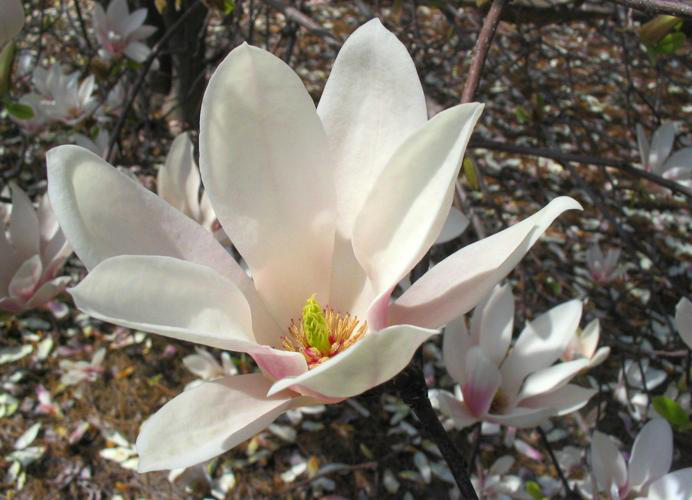

In [36]:
img = Image.open(image_path)
img

(692, 500)
(692, 957)


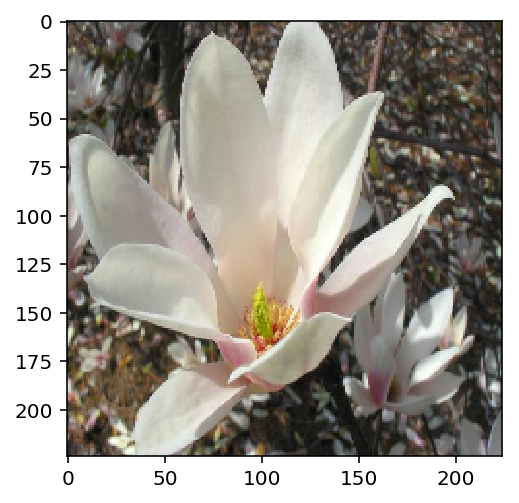

In [37]:
image = process_image(image_path)
imshow(image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [38]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    with torch.no_grad():
        #img = Image.open(image_path)
        #img = test_transforms(img)
        img = process_image(image_path)
        #print(len(img.size()))
        ## Our model expects first dimension as batch_size hence using unsqueeze method 
        ## to translate (3,224,224) to (1,3,224,224)
        output = model.forward(img.unsqueeze(0).to(device) if len(img.size())==3 else img.to(device))
        top_5_probs,classes = output.topk(topk)
        return top_5_probs, classes


In [39]:
predict(image_path,model.cuda())

(692, 500)
(692, 957)


(tensor([[ -0.0090,  -4.7497,  -8.4708, -10.0685, -11.6335]], device='cuda:0'),
 tensor([[ 88,  73,  46,  89,  68]], device='cuda:0'))

In [40]:
probs_tensor, classes_tensor = predict(image_path,model.cuda())
# Convert the probabilities and classes tensors into lists
probs = probs_tensor.tolist()[0]
model.class_to_idx = cat_to_name
classes = [model.class_to_idx[str(sorted(model.class_to_idx)[i])] for i in (classes_tensor).tolist()[0]]

print(probs)
print(classes)

(692, 500)
(692, 957)
[-0.0002193450927734375, -9.414203643798828, -9.521472930908203, -10.521341323852539, -10.724945068359375]
['magnolia', 'oxeye daisy', 'ruby-lipped cattleya', 'water lily', 'cyclamen']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

(692, 500)
(692, 957)


<Container object of 5 artists>

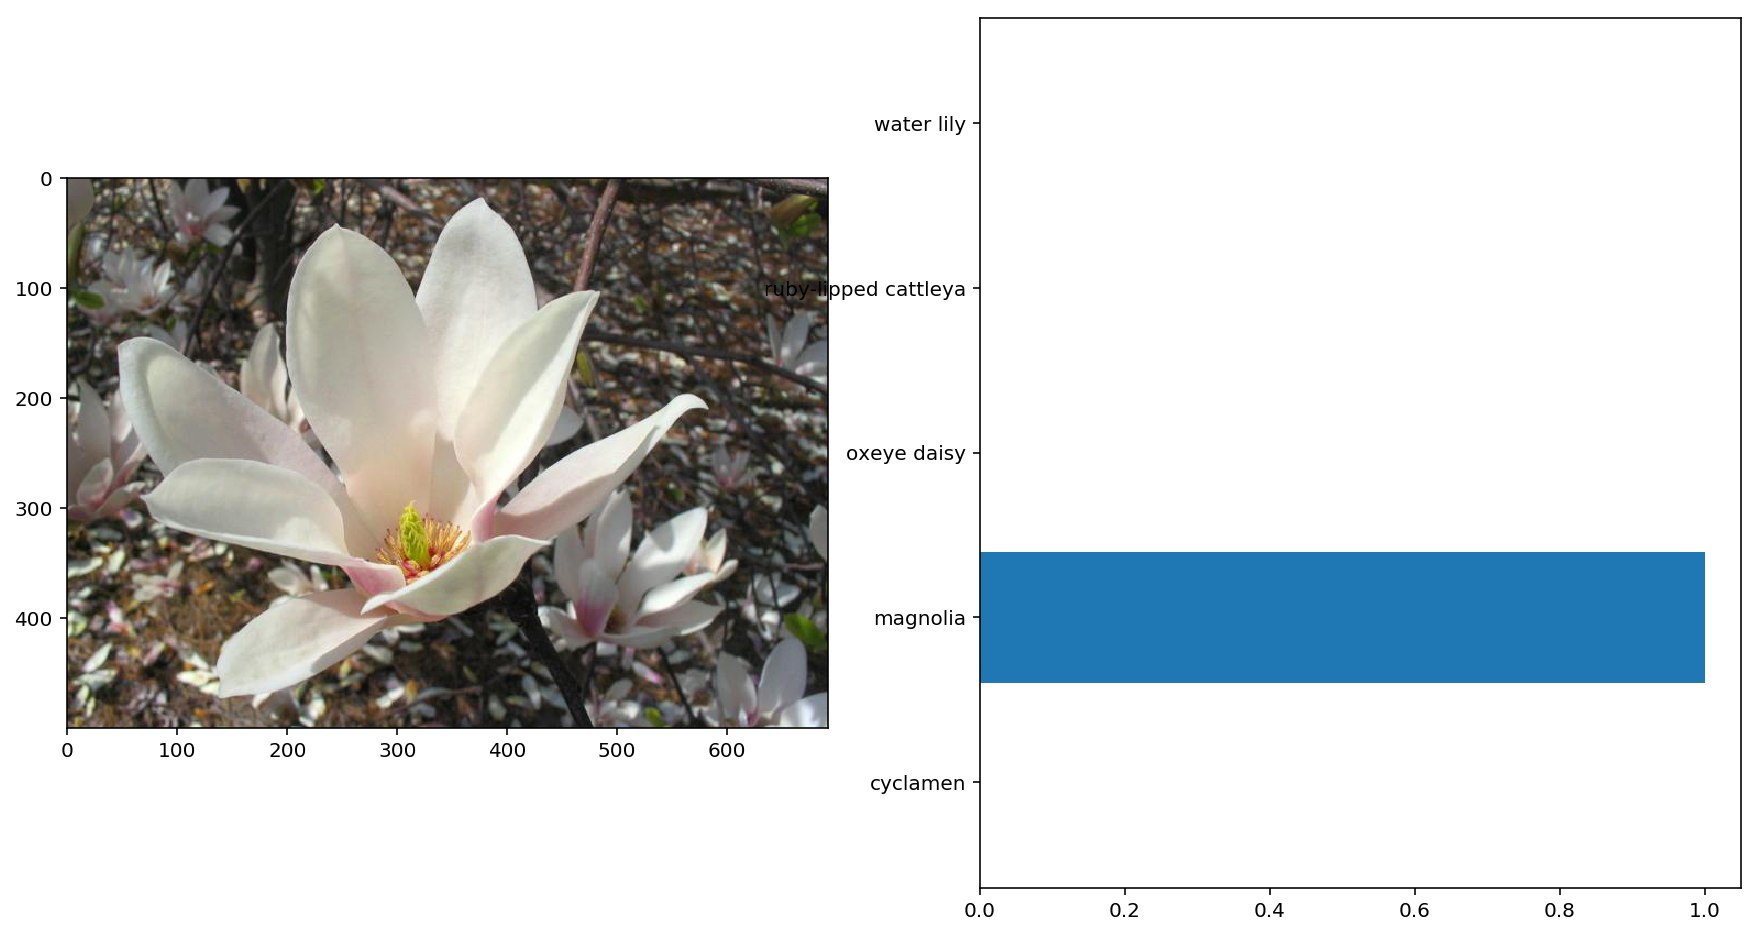

In [41]:

## We are using subplot to show 2 images next to each other. Here (1,2) is 1 row and 2 columns. 
## Third 1 puts image in first position.
plt.rcParams['figure.figsize'] = 15,8
plt.subplot(121)

## We get inverse dictionary as we get indexes from our model and we convert it to key of cat_to_json dictionary.
class_to_idx2 = dict(zip(model.class_to_idx.values(),model.class_to_idx.keys()))
plt.imshow(Image.open(image_path))
probs2, idx2 = predict(image_path,model)

## From indexes we get key of cat_to_name and then cat_to_name gives us flower name..
probs = probs2.data[0].cpu().numpy()
probs = np.exp(probs)

## Third value 2 puts image in 2nd place
plt.subplot(122)
## barh puts bar chart in horizontal position. only bar method puts chart vertically.

plt.barh(classes,probs)


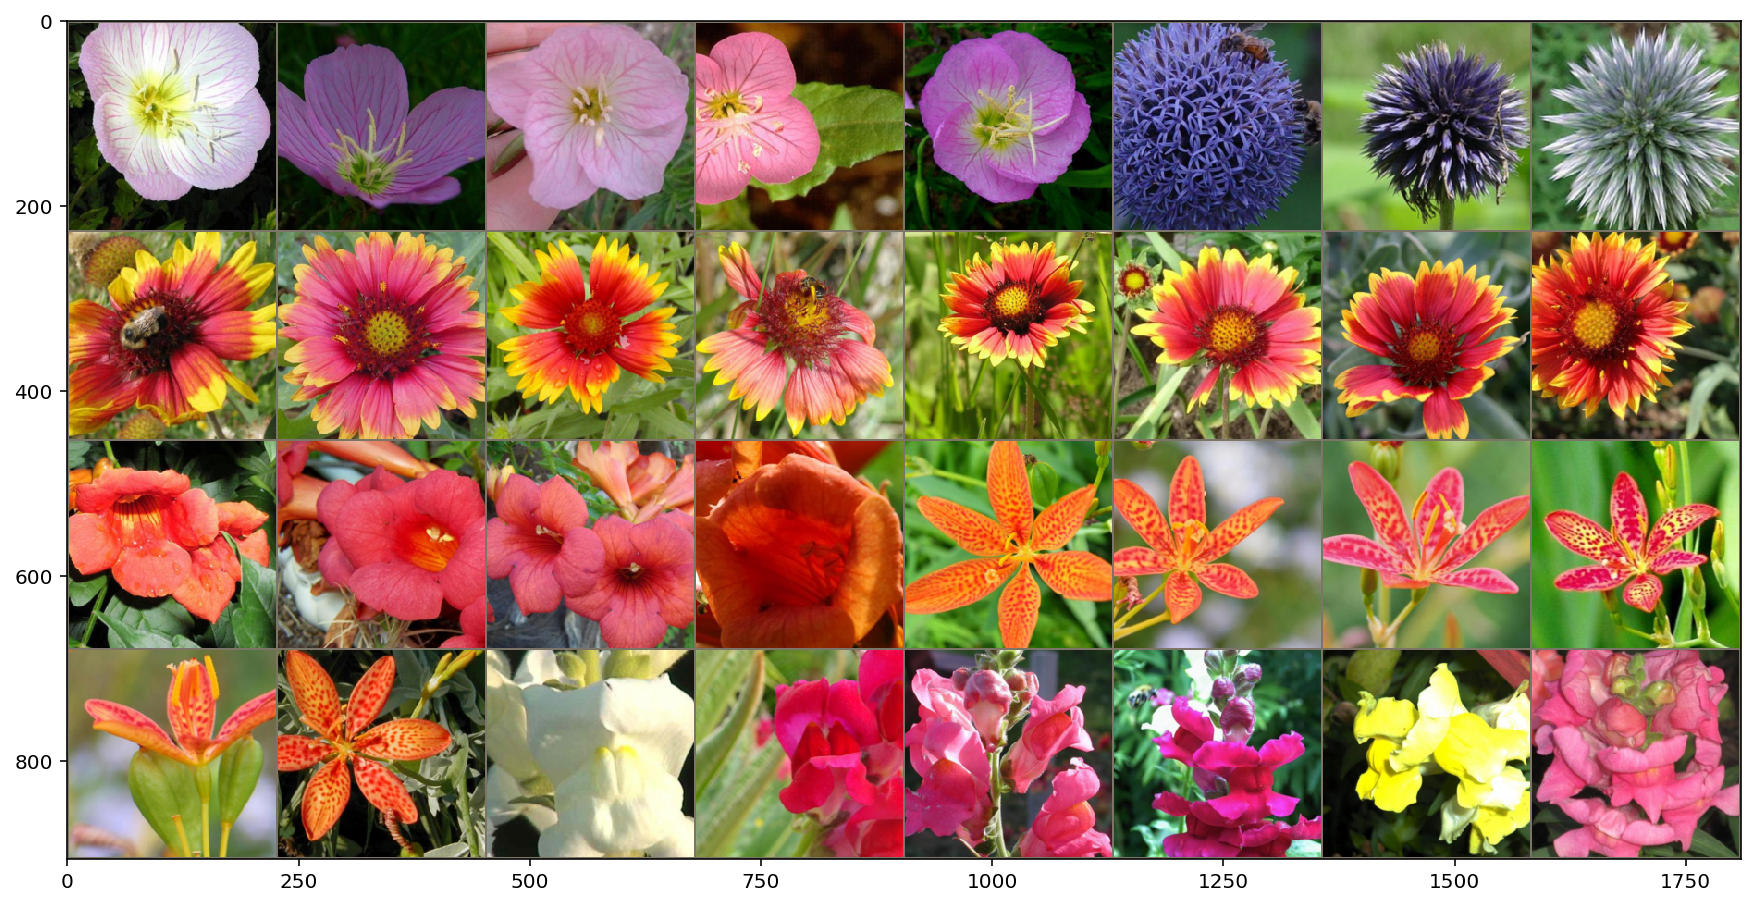

In [42]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [43]:
%ls


assets/           checkpoint.pth                  LICENSE     train.py
cat_to_name.json  flowers/                        predict.py
checkpoint_1.pth  Image Classifier Project.ipynb  README.md
